In [ ]:
use_gpu = True
load_previous_model = True
folder = "/content/drive/Shareddrives/DATA/DATA SCIENCE/MACHINE LEARNING MODELS/transformers/sentiment-analysis"

# Install packages

In [ ]:
########################################
# example code
!pip install transformers --quiet
from transformers import pipeline
sa = pipeline("sentiment-analysis", top_k = None,
              model = "cardiffnlp/twitter-roberta-base-sentiment-latest",
              device = 0, padding = True, truncation = True,
              max_length = 512,
              verbose = False)

print(sa("China slowdown weighs on revenue growth at internet giant Alibaba"))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.6 MB/s eta 0:00:00


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[[{'label': 'negative', 'score': 0.4918711185455322}, {'label': 'neutral', 'score': 0.47751426696777344}, {'label': 'positive', 'score': 0.030614644289016724}]]


In [ ]:
!pip install clean-text --quiet
!pip install unidecode --quiet
!pip install gspread --quiet
!pip install vaderSentiment --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.2 MB/s eta 0:00:00


# Prep data, load packages

In [ ]:
#####################################
# basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import timeit
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import re

# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#####################################
# clean text
from cleantext.sklearn import CleanTransformer

cleaner = CleanTransformer(
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=False,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

#####################################
# connecting with Google Drive
import gspread
from google.colab import auth
auth.authenticate_user()
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

#####################################
# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#####################################
# ML
from transformers import pipeline
from transformers import AutoTokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import torch


Mounted at /content/drive


In [ ]:
#####################################
# load and clean data
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1BQiqe04bIJAqBXU4ealNdPXjIlODdbvQC_acq54IjMQ/edit?usp=sharing')
sheets = gsheets.sheet1.get_all_values()
df = pd.DataFrame(sheets[1:], columns=sheets[0]).set_index("doc_id")
df = df[["text", "label", "source"]]

df["text"] = cleaner.transform(df["text"])
df["label"] = df["label"].astype(int)

# Test-train split

In [ ]:
# test and train datasets
df_test = df[df["source"] == "MAPEGY_TEST"]
df_train = df[df["source"] == "MAPEGY_TRAIN"]

# Compute sentiment from VADER

In [ ]:
######################################
# label with VADER
analyzer = SentimentIntensityAnalyzer()

# find best threshold first
scores = []
for s in df_train['text']:
  score = analyzer.polarity_scores(s)['compound']
  scores.append(score)

from sklearn.metrics import accuracy_score
accuracy = []
threshs = np.linspace(1, 0, 101)
for thresh in threshs:
  labels = []
  for score in scores:
    if score > 1 - thresh:
      labels.append(1)
    elif score < -1 + thresh:
      labels.append(-1)
    else:
      labels.append(0)
  accuracy.append(accuracy_score(labels, df_train["label"]))

thresh = threshs[pd.Series(accuracy).idxmax()]
print("Optimal polarity threshold for VADER:", thresh)



Optimal polarity threshold for VADER: 0.63


In [ ]:
######################################
# use optimal threshold to label

tic = timeit.default_timer()
scores = []
labels = []
for s in df_test['text']:
  score = analyzer.polarity_scores(s)['compound']
  scores.append(score)

  if score > 1 - thresh:
    labels.append(1)
  elif score < -1 + thresh:
    labels.append(-1)
  else:
    labels.append(0)

df_test['vader'] = [int(x) for x in labels]
df_test['score_vader'] = scores

toc = timeit.default_timer()
runtime_vader = round(toc - tic, 3)
print('Runtime VADER sentiment analysis: ', runtime_vader, ' secs.')

Runtime VADER sentiment analysis:  0.428  secs.


<ipython-input-9-fe19ac7b4aac>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['vader'] = [int(x) for x in labels]
<ipython-input-9-fe19ac7b4aac>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score_vader'] = scores


# Compute sentiment from pre-trained model

In [ ]:
#model_name = "cardiffnlp/twitter-roberta-base-sentiment"
#model_name = "finiteautomata/bertweet-base-sentiment-analysis"
#model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

if use_gpu:
  device = 0
else:
  device = -1

if model_name in ["finiteautomata/bertweet-base-sentiment-analysis"]:
  labs = {"NEG": "NEG", "NEU": "NEU", "POS": "POS"}
  max_length = None
if model_name in ["cardiffnlp/twitter-roberta-base-sentiment"]:
  labs = {"NEG": "LABEL_0", "NEU": "LABEL_1", "POS": "LABEL_2"}
  max_length = 512
if model_name in ["cardiffnlp/twitter-roberta-base-sentiment-latest"]:
  labs = {"NEG": "negative", "NEU": "neutral", "POS": "positive"}
  max_length = 512
if model_name in ["mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"]:
  labs = {"NEG": "negative", "NEU": "neutral", "POS": "positive"}
  max_length = None

sa = pipeline("sentiment-analysis", top_k = None, model = model_name, device = device, padding = True, truncation = True, max_length = max_length)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
tic = timeit.default_timer()
Y = sa(list(df_test["text"]))

labels = []
scores = []

for y in Y:
  score = 0
  for x in y:
    if x['label'] == labs['POS']:
      score += x['score']
    elif x['label'] == labs['NEG']:
      score -= x['score']

  scores.append(score)

  y = y[0]
  if y['label'] == labs['POS']:
    labels.append(1)
  elif y['label'] == labs['NEG']:
    labels.append(-1)
  else:
    labels.append(0)

df_test['pretrained'] = [int(x) for x in labels]
df_test['score_pretrained'] = [round(x, 3) for x in scores]
toc = timeit.default_timer()

runtime_pretrained = round(toc - tic, 3)
print('Runtime sentiment analysis: ', runtime_pretrained, ' secs.')

Runtime sentiment analysis:  6.436  secs.


<ipython-input-11-38a99f79a033>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pretrained'] = [int(x) for x in labels]
<ipython-input-11-38a99f79a033>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score_pretrained'] = [round(x, 3) for x in scores]


# Finetune model

In [ ]:
####################################
# load tokenizer
pretrained = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained)

In [ ]:
X_test = dict(tokenizer(list(df_test["text"]), return_tensors="np", truncation=True, padding=True))
y_test = []

for s in list(df_test["label"]):
  if s == -1:
    y_test.append(np.array([1, 0, 0]))
  if s == 0:
    y_test.append(np.array([0, 1, 0]))
  if s == 1:
    y_test.append(np.array([0, 0, 1]))

y_test = np.array(y_test)

In [ ]:
####################################
# make results reproducable
# doesn't work?
np.random.seed(123)
tf.random.set_seed(321)

if load_previous_model:
  model = TFAutoModelForSequenceClassification.from_pretrained(folder)
  print("Loaded model from Google Drive")
else:
  tic = timeit.default_timer()
  #################################
  # prep training data
  X = tokenizer(list(df_train["text"]), return_tensors="np", truncation=True, padding=True)
  # Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
  X = dict(X)

  # one-hot encoding to make sure input is interpeted as intended
  y = []
  for s in list(df_train["label"]):
    if s == -1:
      y.append(np.array([1, 0, 0]))
    if s == 0:
      y.append(np.array([0, 1, 0]))
    if s == 1:
      y.append(np.array([0, 0, 1]))

  y = np.array(y)

  ####################################
  # fit model
  # Lower learning rates are often better for fine-tuning transformers
  model = TFAutoModelForSequenceClassification.from_pretrained(pretrained, num_labels=3)
  model.compile(optimizer=Adam(3e-5), loss=CategoricalCrossentropy(from_logits=True), metrics = ['categorical_accuracy'])
  model.fit(X, y, batch_size=16, epochs=6, validation_data=(X_test, y_test))

  toc = timeit.default_timer()
  print('Runtime model finetuning: ', round(toc - tic, 3), ' secs.')

  model.save_pretrained(folder)
  print("Saved model to Google Drive")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/Shareddrives/DATA/DATA SCIENCE/MACHINE LEARNING MODELS/transformers/sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Loaded model from Google Drive


In [ ]:
tic = timeit.default_timer()

if use_gpu:
  predictions = model.predict(X_test)
else:
  with tf.device('/cpu:0'):
      predictions = model.predict(X_test)
  ########################################################
  # USE A QUANTIZED MODEL?
  # https://medium.com/microsoftazure/faster-and-smaller-quantized-nlp-with-hugging-face-and-onnx-runtime-ec5525473bb7


labels = []
scores = []
for s in predictions.logits:
  s = softmax(s)
  score = -s[0] + s[2]
  scores.append(score)

  pos = pd.Series(s).idxmax()
  if pos == 0:
    labels.append(-1)
  elif pos == 1:
    labels.append(0)
  else:
    labels.append(1)

toc = timeit.default_timer()
runtime_finetuned = round(toc - tic, 3)
print('Runtime prediction: ', runtime_finetuned, ' secs.')

df_test["finetuned"] = labels
df_test["score_finetuned"] = [round(s, 3) for s in scores]

10/10 [==============================] - 10s 549ms/step
Runtime prediction:  10.607  secs.


<ipython-input-15-531d419d98e4>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["finetuned"] = labels
<ipython-input-15-531d419d98e4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["score_finetuned"] = [round(s, 3) for s in scores]


# Evaluation

In [ ]:
for x in [-1, 0, 1]:
  acc = str(round(accuracy_score(df_test['label'], [x] * len(df_test["label"])), 3))
  print("Accuracy always guessing:", x, ':', acc)

Accuracy always guessing: -1 : 0.217
Accuracy always guessing: 0 : 0.46
Accuracy always guessing: 1 : 0.323


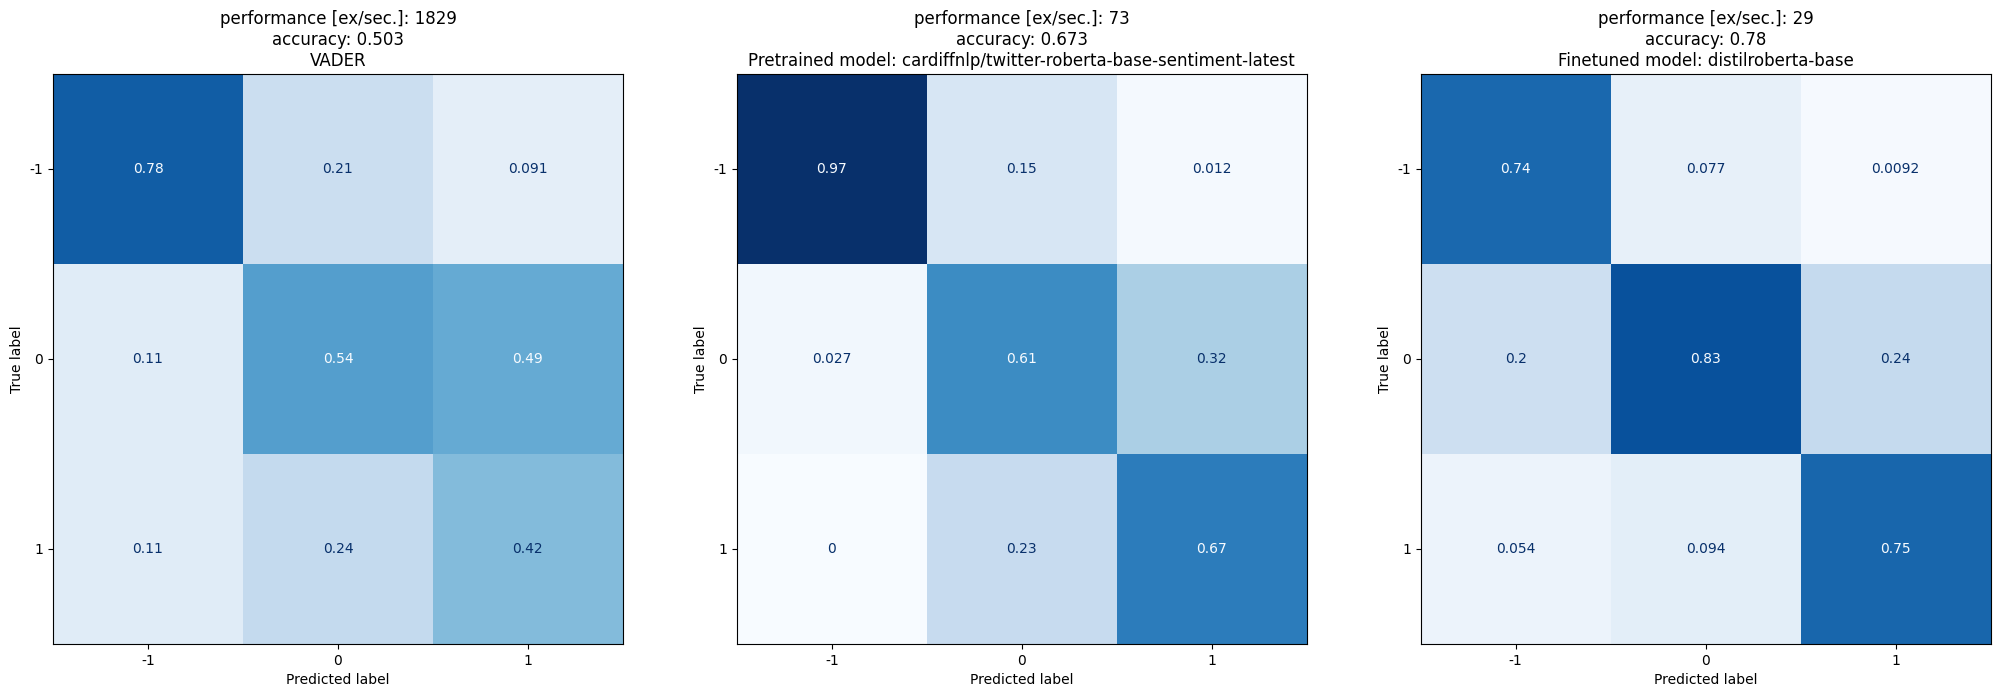

In [ ]:
#####################################
# plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(12)
fig.set_figwidth(25)

CM_VADER = ConfusionMatrixDisplay(confusion_matrix(df_test['label'], df_test['vader'], labels = [-1, 0, 1], normalize = "pred"), display_labels = [-1, 0, 1])
CM_pretrained = ConfusionMatrixDisplay(confusion_matrix(df_test['label'], df_test['pretrained'], labels = [-1, 0, 1], normalize = "pred"), display_labels = [-1, 0, 1])
CM_finetuned = ConfusionMatrixDisplay(confusion_matrix(df_test["label"], df_test["finetuned"], labels = [-1, 0, 1], normalize = "pred"), display_labels = [-1, 0, 1])

CM_VADER.plot(ax=ax1, cmap = "Blues", colorbar = False)
CM_VADER.ax_.title.set_text('performance [ex/sec.]: ' + str(round(df_test.shape[0] / runtime_vader)) + '\naccuracy: ' + str(round(accuracy_score(df_test['label'], df_test['vader']), 3)) + '\nVADER')
CM_VADER.ax_.get_images()[0].set_clim(0, 0.95)

CM_pretrained.plot(ax=ax2, cmap = "Blues", colorbar = False)
CM_pretrained.ax_.title.set_text('performance [ex/sec.]: ' + str(round(df_test.shape[0] / runtime_pretrained)) + '\naccuracy: ' + str(round(accuracy_score(df_test['label'], df_test['pretrained']), 3)) + "\nPretrained model: " + model_name)
CM_pretrained.ax_.get_images()[0].set_clim(0, 0.95)

CM_finetuned.plot(ax=ax3, cmap = "Blues", colorbar = False)
CM_finetuned.ax_.title.set_text('performance [ex/sec.]: ' + str(round(df_test.shape[0] / runtime_finetuned)) + '\naccuracy: ' + str(round(accuracy_score(df_test['label'], df_test['finetuned']), 3)) + "\nFinetuned model: " + pretrained)
CM_finetuned.ax_.get_images()[0].set_clim(0, 0.95)

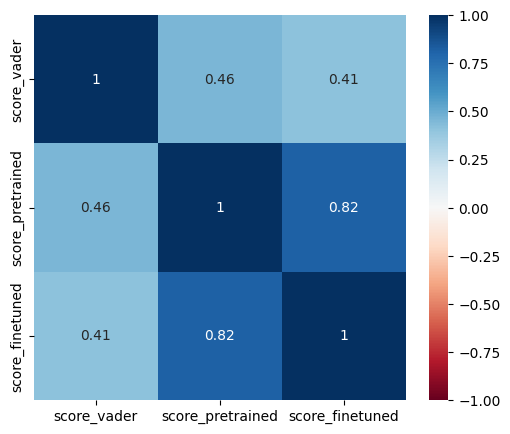

In [ ]:
####################################################################################
# examine correlations of predictions
data = df_test[["score_vader", "score_pretrained", "score_finetuned"]]

correlations = data.corr(method = "spearman")

plt.figure(figsize=(6, 5))
sns.heatmap(round(correlations, 2), cmap='RdBu', annot=True, vmin=-1, vmax=1, cbar = True);

In [ ]:
############################
# extract some examples
"""
import re
sstr = "\\belectric\\b"

for index, s in df_test.iterrows():
  if bool(re.search(sstr, s["text"])):
    idx.append(index)
"""

idx = ["944580298", "467867701", "467857841", "1168933735", "470933774", "1168961164", "537896110", "944858719", "530305683"]
df_test.loc[idx]

,text,label,source,vader,score_vader,pretrained,score_pretrained,finetuned,score_finetuned
doc_id,,,,,,,,,
944580298,Tesla's Next-Gen Roadster Seems To Break Down ...,-1,MAPEGY_TEST,-1,-0.493,0,-0.347,-1,-0.986
467867701,China slowdown weighs on revenue growth at int...,-1,MAPEGY_TEST,1,0.448,0,-0.355,-1,-0.987
467857841,"Sydney is flooded, again, as climate crisis be...",-1,MAPEGY_TEST,-1,-0.883,0,-0.314,-1,-0.984
1168933735,Smart metering major component of Tauron's upd...,0,MAPEGY_TEST,1,0.758,0,0.229,0,0.007
470933774,Wireless Power Transmission Market Trends Anal...,0,MAPEGY_TEST,1,0.802,0,0.069,0,0.001
1168961164,VIDEO: Pros And Cons Of Condition Monitoring S...,0,MAPEGY_TEST,1,0.542,0,0.063,0,-0.004
537896110,Vertex Global Services wins Multiple Brand Opu...,1,MAPEGY_TEST,1,0.950,1,0.918,1,0.990
944858719,How air quality and weather data help cities b...,1,MAPEGY_TEST,1,0.957,1,0.756,1,0.991
530305683,Gene Therapy Sees Encouraging Success In Child...,1,MAPEGY_TEST,1,0.796,1,0.600,1,0.988


In [ ]:
############################
# extract some examples
# based on a text query
import re
sstr = "elec|charg|tesla"

idx = []
for index, s in df_test.iterrows():
  if bool(re.search(sstr, s["text"])):
    idx.append(index)

df_test[["text", "label", "vader", "finetuned"]].loc[idx].sort_values(["label","vader","finetuned"])

,text,label,vader,finetuned
doc_id,,,,
249585490,Why do rechargeable Lithium Ion & Lithium Poly...,-1,-1,-1
944580298,Tesla's Next-Gen Roadster Seems To Break Down ...,-1,-1,-1
159289318,Baltimore Police Chief Says 'We Are Part of th...,-1,-1,-1
373833805,How the Pentagon is tackling deepfakes as a na...,-1,1,-1
882107837,Connect servo and DC motor to Raspberry Pi. I'...,0,-1,0
158903435,When to trust a cur: Forays in wearable pain-r...,0,-1,0
724142082,Elon Musk responds to question on Uber tie-up ...,0,0,0
1168489206,Laird develops micro thermoelectric cooler for...,0,0,1
881728492,Ultrafast imaging of terahertz electric wavefo...,0,0,1


In [ ]:
##########################################
# extract some short text examples
max_char = 120
idx = []
for index, s in df_test.iterrows():
  if len(s["text"]) <= max_char:
    idx.append(index)

df_test[["text", "label", "vader", "finetuned"]].loc[idx].sort_values(["label","vader","finetuned"])

,text,label,vader,finetuned
doc_id,,,,
944595090,The West just experienced an aspect of the cli...,-1,-1,-1
724141922,"Climate, land use change threaten sustainable ...",-1,-1,-1
944847300,Climate change is making flooding worse: 3 rea...,-1,-1,-1
1174415598,Boiler ban risks pushing rural residents into ...,-1,-1,-1
944875421,Elite Dangerous Devs Cancel All Future Console...,-1,-1,-1
111134,Founder Of Mammoth 'De-Extinction' Company Res...,-1,0,-1
981713880,Self Magazine Pitches Obesity As 'Future Of Fi...,-1,0,-1
210923143,Footage Of Early Attempts At Cryonics Has Emer...,-1,0,-1
333456046,Wellington Management Does Not Support Bristol...,-1,0,0


# Plot confusion matrices one by one

<Figure size 500x500 with 0 Axes>

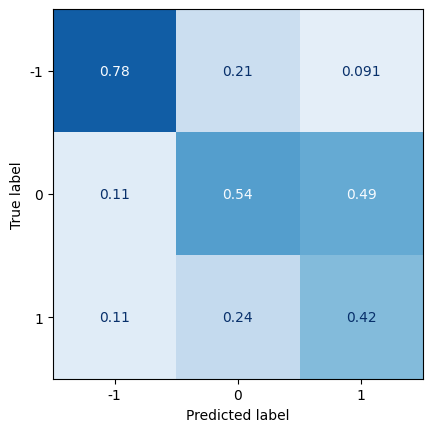

In [ ]:
plt.figure(figsize=(5, 5))
CM_VADER.plot(cmap = "Blues", colorbar = False)
#CM_VADER.ax_.title.set_text('accuracy: ' + str(round(accuracy_score(df_test['label'], df_test['vader']), 3)) + '\nVADER')
CM_VADER.ax_.get_images()[0].set_clim(0, 0.95)

<Figure size 500x500 with 0 Axes>

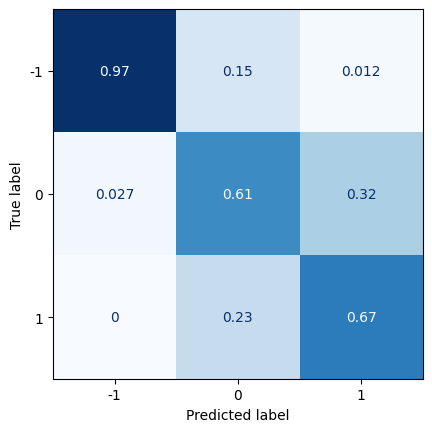

In [ ]:
plt.figure(figsize=(5, 5))

CM_pretrained.plot(cmap = "Blues", colorbar = False)
#CM_pretrained.ax_.title.set_text('accuracy: ' + str(round(accuracy_score(df_test['label'], df_test['pretrained']), 3)) + "\nPretrained model: " + model_name)
CM_pretrained.ax_.get_images()[0].set_clim(0, 0.95)

<Figure size 500x500 with 0 Axes>

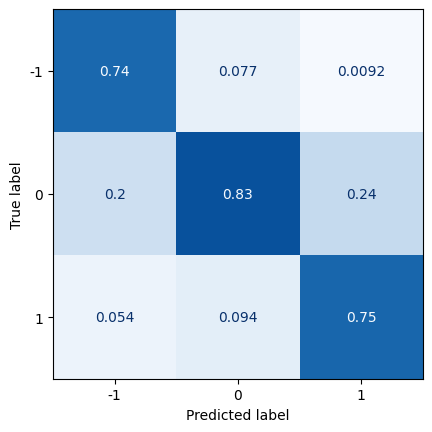

In [ ]:
plt.figure(figsize=(5, 5))

CM_finetuned.plot(cmap = "Blues", colorbar = False)
#CM_finetuned.ax_.title.set_text('accuracy: ' + str(round(accuracy_score(df_test['label'], df_test['finetuned']), 3)) + "\nFinetuned model: " + pretrained)
CM_finetuned.ax_.get_images()[0].set_clim(0, 0.95)